# Installing dependencies and defining helper functions:

In [409]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install "gymnasium[classic-control]"
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

import gymnasium as gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# Loading CartPole environment




In [410]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Task 1: Development of an RL agent

## Q-learning for CartPole Environment

In this notebook, we will apply **Q-learning** to solve the CartPole environment. Q-learning is a model-free reinforcement learning (RL) algorithm that uses a Q-table to store the **state-action values** and updates them iteratively based on the rewards received by the agent.

In the following sections, we'll explore the variables in this environment and how they related to the classic Q-learning formula. Afterwhich, we will dive into the steps to implement Q-learning to train an agent to balance the CartPole.


### Explanation of Variables

**observation = env.reset()**
* Gives a random initial state
* Reset needs to be called after every episode

**env.step(x)**
* After the TD error is 0, meaning that Q(s,a) values have stabilised, the optimal policy (optimal action) is extracted and used in place of x
* Returns:
  * observation: the next state (observation)
  * reward: the reward for the current state
  * terminated = agent reaches a specific condition state (goal or out of bounds etc.)
  * truncation =  the agent reaches the time limit (maximum number of steps) e.g agent taking too long to find a solution


Q-learning formula:
$$
Q_{\text{new}}(s,a) \leftarrow Q_{\text{old}}(s,a) + \alpha \left( r + \gamma \cdot \max_a Q_{\text{old}}(s',a) - Q_{\text{old}}(s,a) \right)
$$

## Task 1.1 Discretizing The State Space And The Motivation Behind It
Q-learning works best with discrete values. In this environment, the states in the observation space are continuous values. As such, before running the agent, we need to discretize the continuous state space and map them into finite values for each observation (cart position, cart velocity, pole angle, and pole angular velocity).

There are 2 ways to discretize the values:
1. Linear interpolation
2. Dividing into bins



### Which method to choose to discretize values?
Since the energy needed to move the cart and the cart's velocity depends on the pole angle, this means that the pole angle velocity and pole angle should have more accurate values, representative of the actual observation values.


#### Linear interpolation
This method linearly scales each observation value to fit into a finite range and then converts the values to integers by rounding them. It assumes a fixed step size for each state variable (e.g., 0.25 for cart position, 0.25 for cart velocity, etc.).

Pros:
* Simple to implement and guarantees mapping of continuous values to discrete integers.

Cons:
* Lacks control over the exact discretization range and size, the values are not accurate enough as they are overly generalised (may not work since 2 values do not have defined bounds)

In [411]:
step_size = np.array([0.2, 0.2, 0.01, 0.01]) # 1 degree = 0.017... rad

def discretize(state):
    discrete_state = state/step_size
    return tuple(discrete_state.astype(np.int64))

#### Dividing into bins

This method discretizes the state space by creating bins for each observation variable (cart position, cart velocity, pole angle, and pole angular velocity).

Any value that falls within the range of a bin will be grouped together, leading to a loss of precision. For example, if the range of the second bin is from 0.2 to 0.3, any value within this range will be assigned to the second bin, and its exact original value will no longer be distinguishable.

Since 2 of the observation values are infinite, we will clip these infinite values to a maximum threshold (environment-specific). We will start with a larger threshold, and once the agent is done training, we can replace this with a more accurate representation of the maximum values reached in the environment.

Pros:

* More control over the number of bins and their range for each state variable

Cons:

* Slightly more complex than linear scaling
* Bins needs to be set carefully to ensure that the state space is properly covered


In [412]:
clipped_cart_velocity = 10
clipped_pole_angle_velocity = 10

# create bins for each variable in observation
no_of_bins = 30, 30, 50, 50

def create_bins():
  bins = [np.linspace(-4.8, 4.8, 30),
          np.linspace(-clipped_cart_velocity, clipped_cart_velocity, 30),
          np.linspace(-0.418, 0.418, 50),
          np.linspace(-clipped_pole_angle_velocity, clipped_pole_angle_velocity, 50)]
  return bins

bins = create_bins()
print(bins)

[array([-4.8       , -4.46896552, -4.13793103, -3.80689655, -3.47586207,
       -3.14482759, -2.8137931 , -2.48275862, -2.15172414, -1.82068966,
       -1.48965517, -1.15862069, -0.82758621, -0.49655172, -0.16551724,
        0.16551724,  0.49655172,  0.82758621,  1.15862069,  1.48965517,
        1.82068966,  2.15172414,  2.48275862,  2.8137931 ,  3.14482759,
        3.47586207,  3.80689655,  4.13793103,  4.46896552,  4.8       ]), array([-10.        ,  -9.31034483,  -8.62068966,  -7.93103448,
        -7.24137931,  -6.55172414,  -5.86206897,  -5.17241379,
        -4.48275862,  -3.79310345,  -3.10344828,  -2.4137931 ,
        -1.72413793,  -1.03448276,  -0.34482759,   0.34482759,
         1.03448276,   1.72413793,   2.4137931 ,   3.10344828,
         3.79310345,   4.48275862,   5.17241379,   5.86206897,
         6.55172414,   7.24137931,   7.93103448,   8.62068966,
         9.31034483,  10.        ]), array([-0.418     , -0.40093878, -0.38387755, -0.36681633, -0.3497551 ,
       -0.33269

After creating the bins, we need another function to assign each value in the observation variable to their respective bins. This method is used whenever the agent goes to the next state, whereby, we need to extract the continuous values from the observation variable and make them discrete.

In [413]:
def discretize_state(state):
    observation_vals_idx = []
    for i in range(len(state)):
      index = np.digitize(state[i], bins[i]) - 1
      observation_vals_idx.append(index)
    return tuple(observation_vals_idx)

#### Explanation of np.digitize

Since np.digitize() returns the index of the bin a value belongs to starting from 1, we subtract 1 to ensure the bin index correctly matches Python’s 0-based array indexing. For example, if a state variable falls into the 1st bin, np.digitize() returns 1, but arrays in Python start from index 0.



In [414]:
# Testing to see the difference in methods for converting continuous values to discrete values
env.reset()

done = False
while not done:
  env.render()
  observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
  print(observation)
  print("Linear Interpolation:")
  print(discretize(observation))
  print("Dividing into bins:")
  print(discretize_state(observation), "\n")
  if terminated or truncated:
    done = True

[ 0.01206527 -0.15714411 -0.02400808  0.24155387]
Linear Interpolation:
(np.int64(0), np.int64(0), np.int64(-2), np.int64(24))
Dividing into bins:
(np.int64(14), np.int64(14), np.int64(23), np.int64(25)) 

[ 0.00892239 -0.35191503 -0.019177    0.52656835]
Linear Interpolation:
(np.int64(0), np.int64(-1), np.int64(-1), np.int64(52))
Dividing into bins:
(np.int64(14), np.int64(13), np.int64(23), np.int64(25)) 

[ 0.00188409 -0.15652856 -0.00864563  0.22790487]
Linear Interpolation:
(np.int64(0), np.int64(0), np.int64(0), np.int64(22))
Dividing into bins:
(np.int64(14), np.int64(14), np.int64(23), np.int64(25)) 

[-0.00124648 -0.3515259  -0.00408753  0.51784813]
Linear Interpolation:
(np.int64(0), np.int64(-1), np.int64(0), np.int64(51))
Dividing into bins:
(np.int64(14), np.int64(13), np.int64(24), np.int64(25)) 

[-0.008277   -0.5465901   0.00626943  0.8092402 ]
Linear Interpolation:
(np.int64(0), np.int64(-2), np.int64(0), np.int64(80))
Dividing into bins:
(np.int64(14), np.int64(13), 

In [415]:
# change make the print reflect the actual last output after finalised
print("Bin for the last output: ", end=" ")
print(bins[3][28], end=" to ")
print(bins[3][29])
print("The pole angular velocity of 1.7872598 is stored in between these values.")

Bin for the last output:  1.4285714285714288 to 1.8367346938775508
The pole angular velocity of 1.7872598 is stored in between these values.


Taking the last output as an example, we can see that linear interpolation generalises the pole angular velocity to 178 vs the method of dividing into bins that keeps the precision of the original values.

> ### **Hence, we will use the bin method to discretise the values.**





### **Can explore using a dictionary too**





## Task 1.2 Implementing the Q-learning algorithm



### Creating the Q-table and the motivation behind it
Q-learning uses a Q-table to store estimated state-action values (Q-values) which gets updated at each step transition during training, according to the immediate rewards received by the agent and the expected maximum future reward from the next state.

As such, discretizing the values is an important step, as it allows us to use the Q-table, which requires a finite and countable number of states.

We populate the q-table with random Q-values between 0 and 1 to encourage initial exploration.

In [416]:
# initilising q-table with random values between 0 and 1 (instead of all zeros)
# except for terminal states should be set to 0
# done to encourage initial exploration

q_table_linear = np.random.uniform(0, 1, no_of_bins + (env.action_space.n,))
print(q_table_linear.shape)
print(q_table_linear[0][0][0].shape)
print(q_table_linear[0][0][0])
print(q_table_linear[0][0][0][0])
#print(q_table[0][0][0][0][0])
#print(q_table[0][0][0][0][1])

(30, 30, 50, 50, 2)
(50, 2)
[[2.02512486e-02 8.94124181e-02]
 [5.91240033e-01 8.44094643e-01]
 [9.94386791e-01 9.49029743e-01]
 [7.26955418e-01 7.40672549e-01]
 [3.03123105e-01 4.34585152e-01]
 [6.98913477e-02 5.38917139e-01]
 [7.26633357e-03 2.54383565e-01]
 [9.32962520e-01 8.25539969e-01]
 [1.04540805e-01 2.77219658e-01]
 [1.67552544e-01 7.87817668e-01]
 [9.41236810e-01 7.98407173e-01]
 [7.90014942e-03 4.64667085e-01]
 [4.40265196e-01 8.98704549e-01]
 [6.47567218e-01 5.96734924e-01]
 [9.31625780e-01 9.65099954e-01]
 [1.77333226e-01 9.77442005e-01]
 [1.66529927e-01 6.01990957e-01]
 [8.29561506e-01 4.97927559e-01]
 [6.42830622e-01 4.93336796e-01]
 [1.98226947e-01 5.93965802e-01]
 [8.20889919e-01 5.74555562e-01]
 [6.97714216e-02 4.38140932e-04]
 [4.06972776e-01 8.85307436e-01]
 [5.20666912e-01 5.18182607e-01]
 [5.31630478e-01 4.23717767e-02]
 [1.26487340e-01 6.65145156e-01]
 [4.71586717e-01 4.75534876e-01]
 [4.41022590e-01 4.30569996e-01]
 [5.01889199e-02 9.99088802e-01]
 [7.31190286e-0

Using the no_of_bins initialised above as (30, 30, 50, 50) and considering that there are 2 possible discrete actions an agent can take, we initialise the Q-table with uniformly random values from the range [0, 1).

Each unique combination of the four observation variables (cart position, cart velocity etc.) represents a state and the last dimension stores the Q-value for action 0 and 1 in that state. Thus, for each state, it maps to two Q-values: one for each possible action (left or right) that represent how good the action is to take in the current state.

### Setting terminal states to 0 while leaving other Q(s,a) between 0 to 1

We need to set the Q-values of terminal states to 0 because. once the episode ends, no further actions or rewards are possible. By doing this, we prevent the agent from attempting to take actions from terminal states.

Here, we find the bin that triggers the end of an episode (terminates the episode).

The termination conditions are:
* pole angle > +/- 12 degrees = 0.20944 rad
* cart position > +/- 2.5

Once we find the first bin where the episode ends, we set all other states outside of the defined range (where the agent can still play the episode) to zero, as these are all terminal states.




In [417]:
# states when episode is terminated

# find the starting bin for when pole angle is greater than 12 degrees = 0.20944 rad
pole_ang_find_bin_positive = discretize_state([0, 0, 0.20944, 0])
pole_ang_find_bin_negative = discretize_state([0, 0, -0.20944, 0])
print("The starting bin in which the pole angle is +12 degrees:", pole_ang_find_bin_positive[2])
print("The starting bin in which the pole angle is -12 degrees:", pole_ang_find_bin_negative[2])

cart_pos_find_bin_positive = discretize_state([2.4, 0, 0, 0])
cart_pos_find_bin_negative = discretize_state([-2.4, 0, 0, 0])
print("The starting bin in which the cart position is +2.4:", cart_pos_find_bin_positive[0])
print("The starting bin in which the cart position is -2.4:", cart_pos_find_bin_negative[0])

terminal_states = [
    (21, 0, 36, 0),  # cart position +2.4, pole angle +12 degrees
    (7, 0, 12, 0)  # cart position -2.4, pole angle -12 degrees
]

# set Q-values for all states where the cart position is beyond terminal states
# so when cart position < 7 or cart position > 21)
# and pole angle > 36 or pole angle < 12
for cart_pos in range(no_of_bins[0]):
  for cart_vel in range(no_of_bins[1]):
    for pole_ang in range(no_of_bins[2]):
      for pole_vel in range(no_of_bins[3]):
        if cart_pos < 7 or cart_pos > 21 or pole_ang < 12 or pole_ang > 36:
            q_table_linear[cart_pos][cart_vel][pole_ang][pole_vel] = np.zeros(env.action_space.n)

# checking if the terminal states have been set to 0
print(q_table_linear[21][0][36][0]) # terminal state
print(q_table_linear[15][0][15][30]) # non-terminal state
print(q_table_linear[21][1][36][1]) # terminal state
print(q_table_linear[25][10][0][25]) # terminal state

The starting bin in which the pole angle is +12 degrees: 36
The starting bin in which the pole angle is -12 degrees: 12
The starting bin in which the cart position is +2.4: 21
The starting bin in which the cart position is -2.4: 7
[0.53256418 0.83323708]
[0.27188219 0.78425172]
[0.85695558 0.23309684]
[0. 0.]


### Initialising the learning parameters

After populating the Q-table, the next step is to initialize the learning parameters for the Q-Learning algorithm. Below is an explanation for each parameter:

* alpha: learning rate
  * how much the new Q-value will influence the old Q-value
    * closer to 0 = agent will rely more on previous knowledge
    * closer to 1 = agent will prioritise the new experience over past knowledge
* gamma: discount factor
  * how much the future rewards will be considered in the the Q-value update
    * closer to 0 = agent only cares about immediate rewards
    * closer to 1 = agent places more emphasis on future rewards
* epsilon: exploration rate
  * exploration-exploitation trade-off
  * agent starts with a high exploration rate (random action selection) and this gradually decreases over time (via decay) to shift toward exploitation (selecting best action) as it learns
  * represents the probability (or percentage) that the agent will choose a random action (exploration) over the best-known action (exploitation) during training
* max_episode_length: max no. of steps per episode
  * if the agent does not reach a terminal state (success or failure) before this limit, the episode will be truncated (prevents infinite loops/long episodes)



In [418]:
alpha = 0.2 # learning rate
gamma = 0.9 # how much to discount future rewards
epsilon = 0.95 # exploration rate (start high, reduce over time to encourage exploitation as more episodes are played)
episodes = 20000 # total number of episodes to train
# max_episode_length = 500 # max no. of steps per episode
minimum_epsilon = 0.001 # minimum value for exploration
total_reward = [] # to find avg. later

After initialising the parameters, we define the function that updates the old Q(s,a).

In [419]:
# updates q-value
def q_learning_algorithm(current_state, new_state, action, reward, q_table):
    # discretize new state to update q-table
    current_state = discretize_state(current_state)

    # discretize new state to update q-table
    new_state = discretize_state(new_state)

    # best q-value for the next state
    best_future_q = np.max(q_table[new_state])

    # current Q-value
    current_q = q_table[current_state + (action,)]

    # Q-Learning formula to update Q-value
    q_table[current_state + (action,)] = current_q + alpha * (reward + gamma * best_future_q - current_q)

## Task 1.3 Training the agent


Here, we train the agent using the previously initaliased parameters. As the agent progresses through episodes, we need to implement an epsilon decay strategy. Initially, the agent explores the environment more (with higher epsilon), but over time, as the agent learns and starts receiving better rewards, we want to gradually reduce epsilon. This allows the agent to shift from exploration (trying out random actions) to exploitation (choosing the best-known action based on its current knowledge).

### Strategies for Decaying Epsilon
There are 3 ways to decay epsilon:
* Linear Decay
* Exponential Decay
* Reward-Based Decay

Linear and Exponential Decay does not take into account the performance of the agent in the environment e.g rewards.




#### Linear Decay
Epsilon should decay across the life of an agent to have it learn and act optimally eventually. A common way to do this is by reducing epsilon by a fixed amount or percentage each episode. It leads to a gradual decrease in exploration as more episodes are played, which allows the agent to balance exploration and exploitation effectively.

In [420]:
epsilon_linear_decay = (epsilon - minimum_epsilon) / episodes

In [421]:
def linear_decay(epsilon, epsilon_linear_decay):
  return epsilon - epsilon_linear_decay

#### Exponential Decay
Similarly to linear decay, epsilon is reduced over time. However, psilon decreases rapidly at the beginning and then slows down as training progresses. In the first few epsiodes, the agent quickly moves away from exploration by reducing random actions at a faster rate. As epsilon approaches the minimum value we set, the decay slows down, allowing the agent to focus more on exploitation.

In [422]:
# def exponential_decay(minimum_epsilon, episodes):
#   return max(minimum_epsilon, np.exp(-0.05*episodes))

In [423]:
epsilon_exponential_decay = (minimum_epsilon/epsilon)**(1/episodes)

In [424]:
def exponential_decay(epsilon, epsilon_exponential_decay):
  return epsilon * epsilon_exponential_decay

#### Rewards Based Decay (Step Based Decay)

Reward-based decay modifies epsilon based on the agent's performance rather than simply decaying it after a set number of episodes. Epsilon is only decayed if the reward of the current episode is better than the reward of the previous episode. This ensures that the agent only reduces exploration when it shows improvement.

The key difference between reward-based decay and other strategies is that, while linear and exponential decay adjust epsilon based on the number of episodes or steps, reward-based decay adjusts epsilon only when the agent shows improvement in rewards. This ensures that epsilon is decayed based on performance, rather than an abitrary value.


In [425]:
reward_target = 195 # reward agent aims to reach
steps_to_take = reward_target # how many steps the agent needs to achieve before reducing epsilon
reward_to_achieve = 0 # max reward agent should aim to achieve in each episode
reward_increment = 1 # specifies how much the reward threshold (the target) should increase each time the agent performs better than the previous episode

epsilon_rewards_based_decay = (epsilon - minimum_epsilon)/steps_to_take # calculates how much epsilon should decay based on the difference between the agent's current rewards and its target goal aka its target reward

In [426]:
def rewards_based_decay(prev_reward, reward_to_achieve, epsilon, epsilon_rewards_based_decay):
  if epsilon > minimum_epsilon and prev_reward >= reward_to_achieve:
      epsilon = epsilon - epsilon_rewards_based_decay
      reward_to_achieve = reward_to_achieve + reward_increment
  return epsilon, reward_to_achieve

### Function to Train Agent


In [427]:
# initialise a dictonary to store rewards for different decay strategies (3 decay types)
rewards = {
    'linear_decay': [],
    'exponential_decay': [],
    'reward_based_decay': []
}

def train_agent(episodes, epsilon, minimum_epsilon, alpha, gamma, reward_to_achieve, q_table, decay_type):
  cumulative_avg = []
  most_recent_avg = []
  no_of_steps_arr = []
  for episode in range(episodes):
      current_state, info = env.reset()
      done = False
      episode_reward = 0
      no_of_steps = 0
      # max steps (truncation) not added yet
      while not done:
        # action selection following epsilon-greedy policy
        if np.random.random() > epsilon: # if larger than epsilon, exploitation: best-known action
          current_state = discretize_state(current_state)
          action = np.argmax(q_table[current_state])
        else:
          action = env.action_space.sample() # if smaller than epsilon, exploration: random action

        # go to next state according to action selection policy
        new_state, reward, terminated, truncated, info = env.step(action)

        # update q-value
        q_learning_algorithm(current_state, new_state, action, reward, q_table)

        # cumulative episode reward
        episode_reward += reward

        # next state becomes the new current state
        current_state = new_state

        no_of_steps+=1

        if truncated:
          print("Truncated, no. of steps: ", no_of_steps)

        # set done to true which stops the episode if truncated or terminated = True
        done = truncated or terminated

      if decay_type == 'linear_decay':
        # linear epsilon decay
        epsilon = linear_decay(epsilon, epsilon_linear_decay)
        rewards['linear_decay'].append(episode_reward)

      elif decay_type == 'exponential_decay':
        # exponential epsilon decay
        epsilon = max(minimum_epsilon, exponential_decay(epsilon, epsilon_exponential_decay)) # ensures that either epsilon decays or it uses the minimum epsilon we defined, its to prevent the epsilon from decaying to a negative value
        rewards['exponential_decay'].append(episode_reward)

      else:
        # reward based decay
        epsilon, reward_to_achieve = rewards_based_decay(episode_reward, reward_to_achieve, epsilon, epsilon_rewards_based_decay)
        rewards['reward_based_decay'].append(episode_reward)

      # periodically print results and calculate average reward based on which decay strategy
      if episode%1000==0:
        print(f"{decay_type.capitalize().replace('_', ' ')}:")
        current_rewards = rewards[decay_type]
        print(f"{episode}: \ncumulative average (0 to current) = {np.average(current_rewards[:episode+1])}\nlast 1000 episodes average = {np.average(current_rewards[-1000:])}\nalpha = {alpha}, epsilon = {epsilon}, steps = {no_of_steps}")
        print("---------------")
        no_of_steps_arr.append(no_of_steps)
        cumulative_avg, most_recent_avg = gatherRewardsData(episode, cumulative_avg, most_recent_avg, decay_type)

  return cumulative_avg, most_recent_avg, no_of_steps_arr

### Function to Calculate Agent Performance

In [428]:
def gatherRewardsData(episode, cumulative_avg, most_recent_avg, decay_type):

    # compute the average reward from episode 0 up to that episode.
    cumulative_avg.append(np.mean(rewards[decay_type][:episode+1]))
    # compute the average of the last 1000 episodes (or fewer if not available yet)
    most_recent_avg.append(np.mean(rewards[decay_type][-(episode-1000):])) if episode > 1000 else most_recent_avg.append(np.mean(rewards[decay_type]))

    return cumulative_avg, most_recent_avg

### Training The Agent Using Different Decay Strategies and Plotting The Graphs For Comparison



To test each decay strategy, it needs to use a fresh Q-table. Otherwise, the episodes will keep being truncated since the agent would have optimal Q-values from previous training using another decay strategy.



In [429]:
q_table_exponential = np.copy(q_table_linear)
q_table_reward_based = np.copy(q_table_linear)

#### Train agent with rewards based decay

In [430]:
# train the agent with rewards based decay
rewards_based_cumulative_avg, rewards_based_most_recent_avg, no_of_steps_reward_based = train_agent(episodes, epsilon, minimum_epsilon, alpha, gamma, reward_to_achieve, q_table_reward_based, decay_type='reward_based_decay')

Reward based decay:
0: 
cumulative average (0 to current) = 10.0
last 1000 episodes average = 10.0
alpha = 0.2, epsilon = 0.9451333333333333, steps = 10
---------------
Reward based decay:
1000: 
cumulative average (0 to current) = 48.116883116883116
last 1000 episodes average = 48.155
alpha = 0.2, epsilon = 0.2297333333333306, steps = 56
---------------
Reward based decay:
2000: 
cumulative average (0 to current) = 100.82058970514743
last 1000 episodes average = 153.577
alpha = 0.2, epsilon = 0.0009999999999973919, steps = 142
---------------
Reward based decay:
3000: 
cumulative average (0 to current) = 121.22459180273242
last 1000 episodes average = 162.053
alpha = 0.2, epsilon = 0.0009999999999973919, steps = 192
---------------
Reward based decay:
4000: 
cumulative average (0 to current) = 135.08572856785804
last 1000 episodes average = 176.683
alpha = 0.2, epsilon = 0.0009999999999973919, steps = 165
---------------
Truncated, no. of steps:  500
Truncated, no. of steps:  500
Trun

#### Train agent with linear decay


In [431]:
# train the agent with linear decay
linear_cumulative_avg, linear_most_recent_avg, no_of_steps_linear = train_agent(episodes, epsilon, minimum_epsilon, alpha, gamma, reward_to_achieve, q_table_linear, decay_type='linear_decay')

Linear decay:
0: 
cumulative average (0 to current) = 16.0
last 1000 episodes average = 16.0
alpha = 0.2, epsilon = 0.94995255, steps = 16
---------------
Linear decay:
1000: 
cumulative average (0 to current) = 23.46853146853147
last 1000 episodes average = 23.476
alpha = 0.2, epsilon = 0.9025025500000511, steps = 16
---------------
Linear decay:
2000: 
cumulative average (0 to current) = 25.373813093453272
last 1000 episodes average = 27.281
alpha = 0.2, epsilon = 0.8550525500001022, steps = 28
---------------
Linear decay:
3000: 
cumulative average (0 to current) = 26.814728423858714
last 1000 episodes average = 29.698
alpha = 0.2, epsilon = 0.8076025500001532, steps = 13
---------------
Linear decay:
4000: 
cumulative average (0 to current) = 28.70782304423894
last 1000 episodes average = 34.389
alpha = 0.2, epsilon = 0.7601525500002043, steps = 45
---------------
Linear decay:
5000: 
cumulative average (0 to current) = 30.4629074185163
last 1000 episodes average = 37.485
alpha = 0

#### Train agent with exponential decay

In [432]:
# train the agent with exponential decay
exponential_cumulative_avg, exponential_most_recent_avg, no_of_steps_exponential = train_agent(episodes, epsilon, minimum_epsilon, alpha, gamma, reward_to_achieve, q_table_exponential, decay_type='exponential_decay')

Exponential decay:
0: 
cumulative average (0 to current) = 22.0
last 1000 episodes average = 22.0
alpha = 0.2, epsilon = 0.9496743738749995, steps = 22
---------------
Exponential decay:
1000: 
cumulative average (0 to current) = 29.944055944055943
last 1000 episodes average = 29.952
alpha = 0.2, epsilon = 0.6740444526779777, steps = 16
---------------
Exponential decay:
2000: 
cumulative average (0 to current) = 38.6151924037981
last 1000 episodes average = 47.295
alpha = 0.2, epsilon = 0.47841232393384153, steps = 76
---------------
Exponential decay:
3000: 
cumulative average (0 to current) = 49.71342885704765
last 1000 episodes average = 71.921
alpha = 0.2, epsilon = 0.3395597290096314, steps = 31
---------------
Exponential decay:
4000: 
cumulative average (0 to current) = 60.36890777305673
last 1000 episodes average = 92.346
alpha = 0.2, epsilon = 0.24100718939890628, steps = 137
---------------
Exponential decay:
5000: 
cumulative average (0 to current) = 73.52829434113177
last 

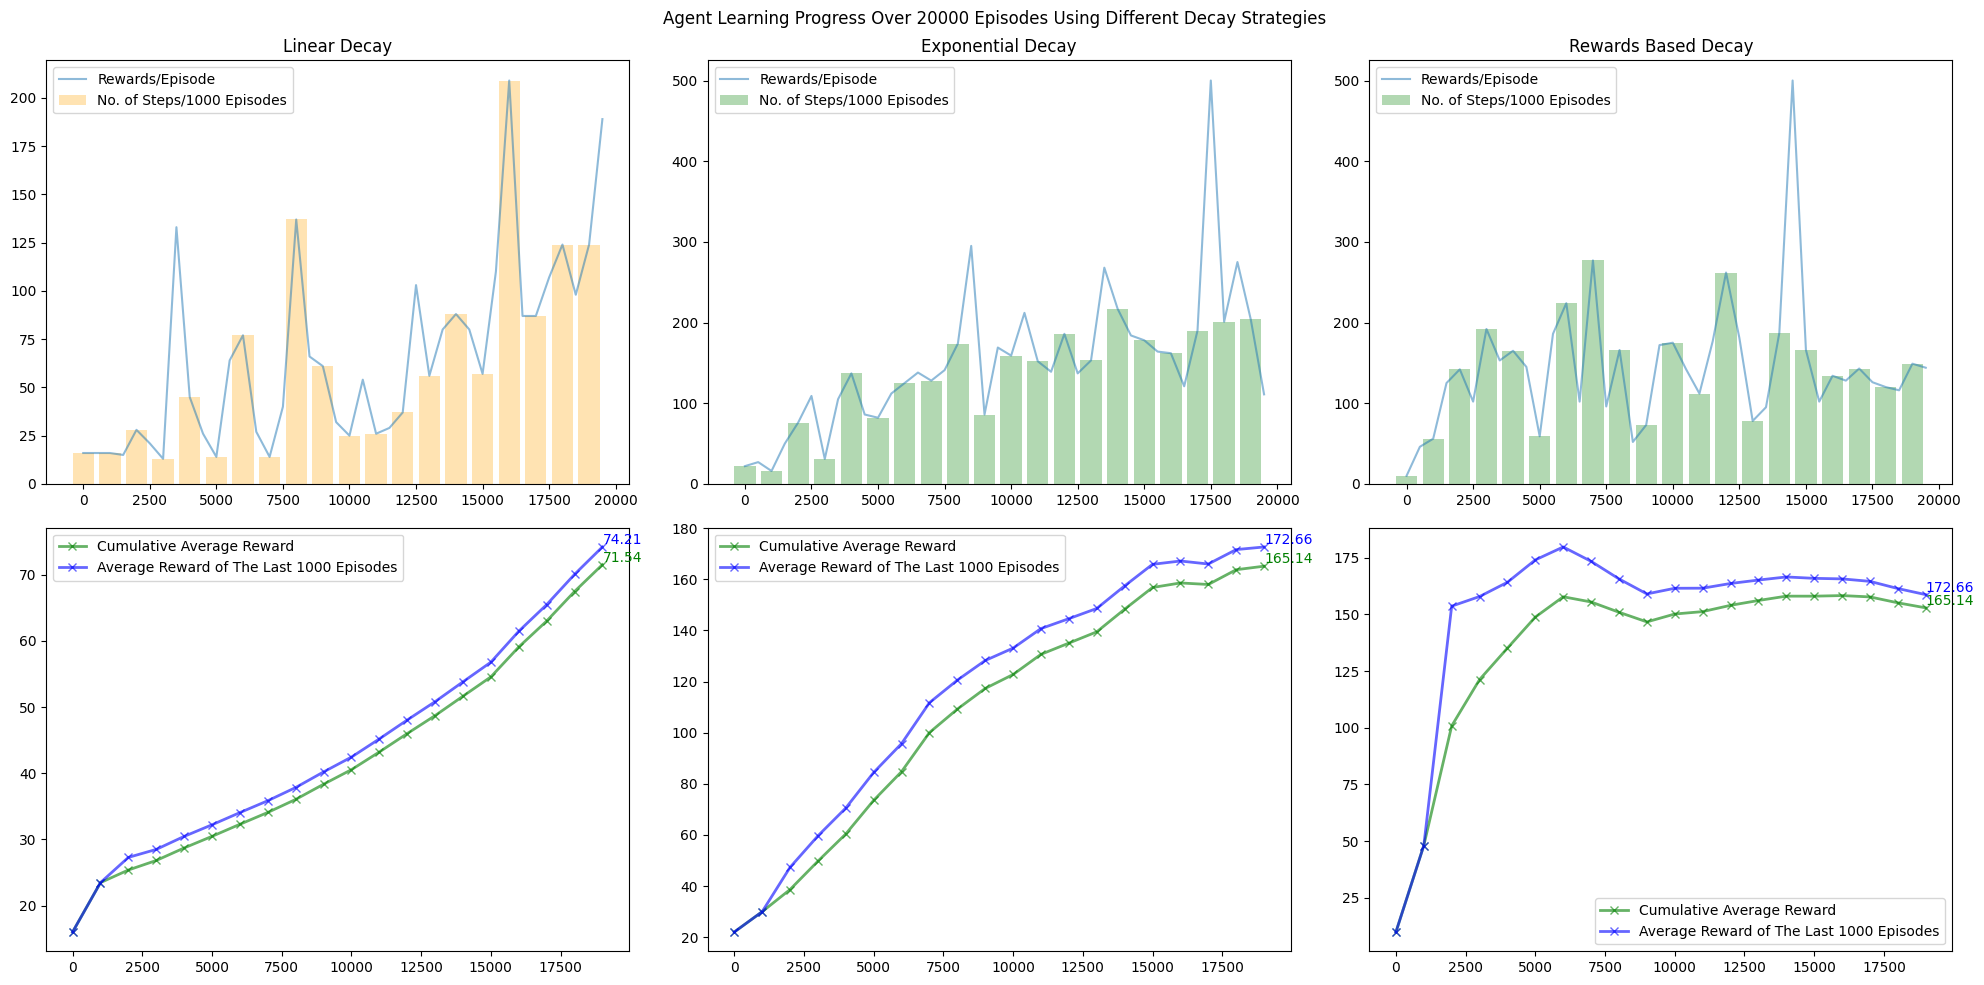

In [433]:
episode_reward_x_axis = np.arange(0, len(rewards['linear_decay']), 500) # given the interval 0 to 20000 episodes, we mark a data point every 500 steps
interval_episodes_x_axis = np.arange(0, episodes, 1000) # given the interval 0 to 20000 episodes, we mark a data point every 1000 steps

plt.figure(figsize=(20,10))

# first row
# subplot 1 - rewards/episode (linear decay)
plt.subplot(2, 3, 1)
plt.plot(episode_reward_x_axis, rewards['linear_decay'][::500], label="Rewards/Episode", alpha=0.5) # ::500 = every 500th element
plt.bar(interval_episodes_x_axis, no_of_steps_linear, width=800, label="No. of Steps/1000 Episodes", alpha=0.3, color='orange') # ::500 = every 500th element
plt.legend()
plt.title("Linear Decay")

# subplot 2 - rewards/episode (exponential decay)
plt.subplot(2, 3, 2)
plt.plot(episode_reward_x_axis, rewards['exponential_decay'][::500], label="Rewards/Episode", alpha=0.5) # ::500 = every 500th element
plt.bar(interval_episodes_x_axis, no_of_steps_exponential, width=800, label="No. of Steps/1000 Episodes", alpha=0.3, color='green') # ::500 = every 500th element
plt.legend()
plt.title("Exponential Decay")

# subplot 3 - rewards/episode (rewards based decay)
plt.subplot(2, 3, 3)
plt.plot(episode_reward_x_axis, rewards['reward_based_decay'][::500], label="Rewards/Episode", alpha=0.5) # ::500 = every 500th element
plt.bar(interval_episodes_x_axis, no_of_steps_reward_based, width=800, label="No. of Steps/1000 Episodes", alpha=0.3, color='green') # ::500 = every 500th element
plt.legend()
plt.title("Rewards Based Decay")

# second row
# subplot 1 - cumulative avg. reward and avg. reward of last 1000 episodes (linear decay)
plt.subplot(2, 3, 4)
plt.plot(interval_episodes_x_axis, linear_cumulative_avg, label="Cumulative Average Reward", linewidth=2, color='green', alpha=0.6, marker='x')
plt.plot(interval_episodes_x_axis, linear_most_recent_avg, label="Average Reward of The Last 1000 Episodes", linewidth=2, color='blue', alpha=0.6, marker='x')
plt.legend()
# annotate the last data point
linear_last_cum_point = linear_cumulative_avg[-1]
linear_last_recent_point = linear_most_recent_avg[-1]
plt.text(interval_episodes_x_axis[-1], linear_last_cum_point, f"{linear_last_cum_point:.2f}", fontsize=10, color='green', ha='left', va='bottom')
plt.text(interval_episodes_x_axis[-1], linear_last_recent_point, f"{linear_last_recent_point:.2f}", fontsize=10, color='blue', ha='left', va='bottom')

# subplot 2 - cumulative avg. reward and avg. reward of last 1000 episodes (exponential decay)
plt.subplot(2, 3, 5)
plt.plot(interval_episodes_x_axis, exponential_cumulative_avg, label="Cumulative Average Reward", linewidth=2, color='green', alpha=0.6, marker='x')
plt.plot(interval_episodes_x_axis, exponential_most_recent_avg, label="Average Reward of The Last 1000 Episodes", linewidth=2, color='blue', alpha=0.6, marker='x')
plt.legend()
# annotate the last data point
exponential_last_cum_point = exponential_cumulative_avg[-1]
exponential_last_recent_point = exponential_most_recent_avg[-1]
plt.text(interval_episodes_x_axis[-1], exponential_last_cum_point, f"{exponential_last_cum_point:.2f}", fontsize=10, color='green', ha='left', va='bottom')
plt.text(interval_episodes_x_axis[-1], exponential_last_recent_point, f"{exponential_last_recent_point:.2f}", fontsize=10, color='blue', ha='left', va='bottom')


# subplot 3 - cumulative avg. reward and avg. reward of last 1000 episodes (reward based decay)
plt.subplot(2, 3, 6)
plt.plot(interval_episodes_x_axis, rewards_based_cumulative_avg, label="Cumulative Average Reward", linewidth=2, color='green', alpha=0.6, marker='x')
plt.plot(interval_episodes_x_axis, rewards_based_most_recent_avg, label="Average Reward of The Last 1000 Episodes", linewidth=2, color='blue', alpha=0.6, marker='x')
plt.legend()
# annotate the last data point
rewards_based_last_cum_point = rewards_based_cumulative_avg[-1]
rewards_based_last_recent_point = rewards_based_most_recent_avg[-1]
plt.text(interval_episodes_x_axis[-1], rewards_based_last_cum_point, f"{exponential_last_cum_point:.2f}", fontsize=10, color='green', ha='left', va='bottom')
plt.text(interval_episodes_x_axis[-1], rewards_based_last_recent_point, f"{exponential_last_recent_point:.2f}", fontsize=10, color='blue', ha='left', va='bottom')

# graph formatting
plt.suptitle("Agent Learning Progress Over 20000 Episodes Using Different Decay Strategies")
plt.tight_layout()
plt.show()

### Task 1.5 Demonstrating Correctness
To conclude Task 1, we will sample a random state from the cart pole environment, input it to the agents, and output a chosen action.

In [434]:
observation, info = env.reset()
# discretize observation to be able to get the corresponding q-value in the q-table
obs_discretised = discretize_state(observation)
print("Observation:", observation, end='\n\n')

print("Linear Decay Q Agent")
linear_action = np.argmax(q_table_linear[obs_discretised]) # argmax to get the action (index) with the highest q-value for the current discretized state
print("Chosen action:", linear_action, end='\n\n')

print("Exponential Decay Q Agent")
exponential_action = np.argmax(q_table_exponential[obs_discretised])
print("Chosen action:", exponential_action, end='\n\n')

print("Reward Based Decay Q Agent")
reward_based_action = np.argmax(q_table_reward_based[obs_discretised])
print("Chosen action:", reward_based_action, end='\n')

Observation: [-0.00696955 -0.0416189  -0.01920676  0.03421514]

Linear Decay Q Agent
Chosen action: 1

Exponential Decay Q Agent
Chosen action: 0

Reward Based Decay Q Agent
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

### Task 2.1 Evaluating the agent


For this task, we will use the three agents with the different decay strategies developed in Task 1 to play the game for 100 episodes, record the cumulative reward for each round, and plot the reward for each episode.

In [435]:
# function to play game for 100 episodes and evaluate the agent
def evaluateAgent(agent_type):
  episode_results = []  # stores the total reward per episode
  for episode in range(100):
    observation, info = env.reset()
    done = False
    episode_reward = 0  # cumulative reward for this single episode
    while not done:
      obs_discretised = discretize_state(observation)
      action = np.argmax(agent_type[obs_discretised])
      observation, reward, terminated, truncated, info = env.step(action)
      if truncated:
        print("Truncated")
      episode_reward += reward
      done = truncated or terminated

    episode_results.append(episode_reward)  # store the final reward for this episode

  episode_results = np.array(episode_results)  # convert to NumPy array so we can use .mean

  print("Average cumulative reward:", episode_results.mean())
  print("Is my agent good enough?", episode_results.mean() > 195)

  return episode_results

In [436]:
def plotEvaluation(all_episode_rewards, agent_names):
    plt.figure(figsize=(18, 5))

    for i, (rewards, name) in enumerate(zip(all_episode_rewards, agent_names), start=1):
        plt.subplot(1, 3, i)
        plt.plot(rewards)
        plt.title(f'{name}')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Reward')

    plt.suptitle('Cumulative Reward per Episode for Different Agents')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Average cumulative reward: 166.99
Is my agent good enough? False
Average cumulative reward: 137.1
Is my agent good enough? False
Truncated
Average cumulative reward: 212.74
Is my agent good enough? True


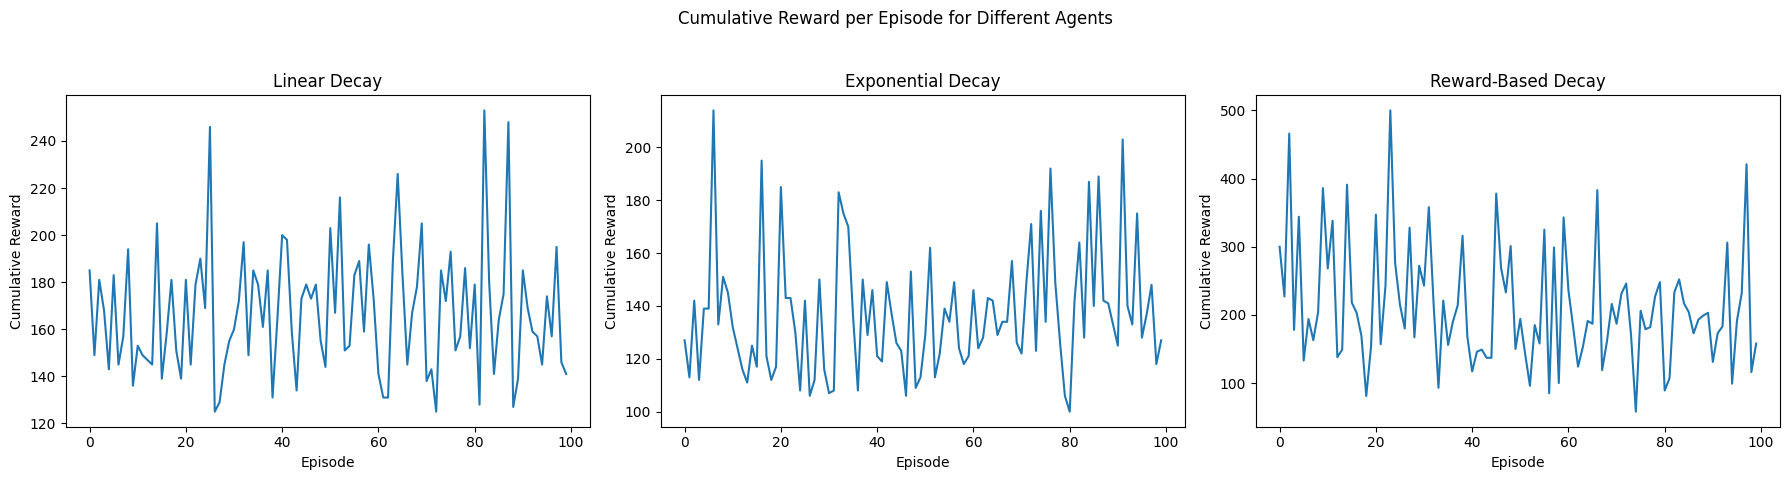

In [437]:
# q-learning agent with linear decay
linear_rewards = evaluateAgent(q_table_linear)

# q-learning agent with exponential decay
exponential_rewards = evaluateAgent(q_table_exponential)
#
# q-learning agent with reward based decay
reward_based_rewards = evaluateAgent(q_table_reward_based)

plotEvaluation(
    [linear_rewards, exponential_rewards, reward_based_rewards],
    ['Linear Decay', 'Exponential Decay', 'Reward-Based Decay']
)

We can see that exponential decay tends to promote faster learning and higher rewards, but can also lead to greater variability. In contrast, linear decay offers steadier but slower improvement, while reward-based decay provides dynamic exploration control at the cost of more reward variability.

This highlights the importance of selecting an epsilon decay strategy aligned with the specific goals of training — whether prioritizing fast convergence, stability, or adaptability.


> **Scenarios and	Best Decay Strategy**
* Exponential Decay: When you want very fast learning but are OK with some mistakes
* Linear Decay: When you want very stable and steady improvement
* Reward-Based Decay: When you want the agent to adjust exploration dynamically based on how well it's doing

#### Conclusion For This Task

Based on the evaluation results, the agent trained with reward-based epsilon decay achieved the highest performance, being the only agent to surpass the threshold of a mean cumulative reward above 195.

Therefore, we select the reward-based decay agent to render an episode, as it demonstrated the best overall learning behavior in this experimental run.

## Task 3: Render one episode played by the agent

### Task 3.1 Rendering and demonstrating policy


In [452]:
from gymnasium.wrappers import RecordVideo

env = gym.make("CartPole-v1", render_mode="rgb_array")
env = RecordVideo(env, "./video")

observation, info = env.reset()
while True:
    env.render()
    discretised_obs = discretize_state(observation)
    action = np.argmax(q_table_reward_based[discretised_obs])
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
      break;
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


# References
What Is Q-Learning? - https://www.simplilearn.com/tutorials/machine-learning-tutorial/what-is-q-learning

Q-Learning Algorithm: From Explanation to Implementation - https://medium.com/data-science/q-learning-algorithm-from-explanation-to-implementation-cdbeda2ea187

Reward-Based Epsilon Decay - https://aakash94.github.io/Reward-Based-Epsilon-Decay/

Strategies for Decaying Epsilon in Epsilon-Greedy - https://medium.com/@CalebMBowyer/strategies-for-decaying-epsilon-in-epsilon-greedy-9b500ad9171d

Epsilon-Greedy Strategy in Q-Learning - https://www.baeldung.com/cs/epsilon-greedy-q-learning

Understanding numpy.digitize() - https://medium.com/@whyamit101/understanding-numpy-digitize-fa6243a29502

Introduction to Q-Learning with OpenAI Gym (Microsoft ML for Beginners) - https://github.com/microsoft/ML-For-Beginners/blob/main/8-Reinforcement/2-Gym/README.md

Learning Q-Learning: Solving and Experimenting with CartPole-v1 from OpenAI Gym (Part 1) - https://madorjan.medium.com/learning-q-learning-solving-and-experimenting-with-cartpole-v1-from-openai-gym-part-1-2164626ed24d

Using Q-Learning for OpenAI’s CartPole-v1 - https://medium.com/swlh/using-q-learning-for-openais-cartpole-v1-4a216ef237df
